<a href="https://colab.research.google.com/github/aiscience-22/UA_War/blob/olgap%2Fmachine_learning_0.04/linear_regression_average.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
spark_version = 'spark-3.2.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:3 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:4 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:5 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:13 http://security.ubuntu.com/ubuntu 

In [3]:
# Add drivers to Spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

# Read the CSV and Perform Basic Data Cleaning

In [17]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url ="https://aiscience22.s3.us-west-1.amazonaws.com/joined.csv"

spark.sparkContext.addFile(url)
text_df = spark.read.csv(SparkFiles.get("joined.csv"), sep=",", header=True, inferSchema=True)


# Show DataFrame
text_df.show()

+-------------+---------+---------+-----------+-------------+--------------+------------+--------------------+--------+--------------+-----------+----------+---------------+----------+--------------------+-----------+-----------+-----------+--------------+----------+
|     username|following|followers|totaltweets|usercreatedts|tweetcreatedts|retweetcount|            hashtags|language|favorite_count|extractedts|is_retweet|is_quote_status|weekofyear|        cleaned_text|   negative|    neutral|   positive|search_results|    weight|
+-------------+---------+---------+-----------+-------------+--------------+------------+--------------------+--------+--------------+-----------+----------+---------------+----------+--------------------+-----------+-----------+-----------+--------------+----------+
|     Theo1001|      312|      123|      38156|   2008-05-14|    2022-04-22|          67|[{''text'': ''Sta...|      en|             0| 2022-04-22|      true|          false|        16|thank you si

In [18]:
# convert spark dataframe to pandas
joined_data_df = text_df.toPandas()
joined_data_df.head(5)




,username,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,hashtags,language,favorite_count,extractedts,is_retweet,is_quote_status,weekofyear,cleaned_text,negative,neutral,positive,search_results,weight
0,Theo1001,312,123,38156,2008-05-14,2022-04-22,67,"[{''text'': ''StandWithUkraine'', ''indices'':...",en,0,2022-04-22,True,False,16,thank you sir we will not forget those who con...,0.010234,0.719316,0.270449,196000.0,0.000985
1,ereguly,4787,9149,22818,2008-12-31,2022-04-24,3,"[{''text'': ''LePen'', ''indices'': [28, 34]},...",en,5,2022-04-24,False,True,16,of course pas de surprise tainted by her close...,0.004823,0.675433,0.319744,94500.0,0.000475
2,davidgodfrey,5003,464,44931,2008-10-12,2022-04-24,97,"[{''text'': ''Mariupol'', ''indices'': [36, 45]}]",en,0,2022-04-24,True,False,16,no corridors from again russians did not allow...,0.018234,0.883309,0.098457,94500.0,0.000475
3,cazacioc,1712,1019,38691,2008-12-06,2022-04-24,500,"[{''text'': ''SlavaUkraini'', ''indices'': [30...",en,0,2022-04-24,True,False,16,thank you,0.169791,0.608387,0.221821,94500.0,0.000475
4,Daily_Express,761,935851,1066678,2008-12-05,2022-04-22,0,"[{''text'': ''Ukraine'', ''indices'': [63, 71]}]",en,2,2022-04-22,False,False,16,president biden unveils m worth of military as...,0.156944,0.766128,0.076928,196000.0,0.000985


# Explore the data if nothing lost

In [7]:
earliest_tweet = joined_data_df["tweetcreatedts"].min()
latest_tweet = joined_data_df["tweetcreatedts"].max()

print(f"The earliest tweet was at {earliest_tweet}, and the latest was at {latest_tweet}")

The earliest tweet was at 2022-04-22, and the latest was at 2022-08-18


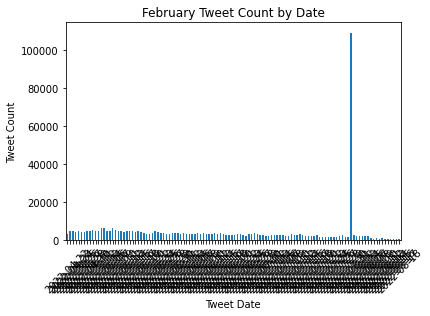

In [9]:
from pandas.core.arrays.datetimelike import DatetimeLikeScalar
from numpy.core.multiarray import datetime_as_string
#Get the plot of tweet count by date 
dates = joined_data_df["tweetcreatedts"]

# group tweet timestamps by date and get tweet count for each date
tweetcount_by_date = joined_data_df["tweetcreatedts"].groupby(dates).size()

# plot bar graph of tweet count by date
tweetcount_by_date.plot.bar();

plt.title("February Tweet Count by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Tweet Count")
plt.xticks(rotation=45)
plt.show()

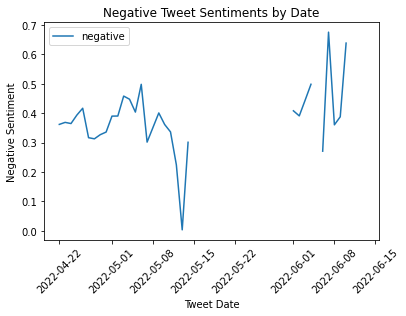

In [8]:
#Get the plot of negative score by date of tweet
negative_df = joined_data_df[['tweetcreatedts', 'negative']]

negative_by_date = negative_df.groupby([negative_df['tweetcreatedts']]).mean()

# plot bar graph of tweet count by date
negative_by_date.plot.line();

plt.title("Negative Tweet Sentiments by Date")
plt.xlabel("Tweet Date")
plt.ylabel("Negative Sentiment")
plt.xticks(rotation=45)
plt.show()


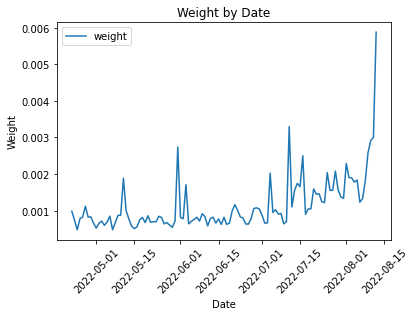

In [10]:
#Get the plot of day weight by date
joined_data_df.plot.line(x='tweetcreatedts', y='weight');

plt.title("Weight by Date")
plt.xlabel("Date")
plt.ylabel("Weight")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# Cleaning and converting the data

In [19]:
# Drop the not needed column
joined_data_df.drop("username", axis=1, inplace=True)
joined_data_df.drop("usercreatedts", axis=1, inplace=True)
joined_data_df.drop("language", axis=1, inplace=True)
joined_data_df.drop("favorite_count", axis=1, inplace=True)
joined_data_df.drop("extractedts", axis=1, inplace=True)
joined_data_df.drop("weekofyear", axis=1, inplace=True)
joined_data_df.drop("neutral", axis=1, inplace=True)
joined_data_df.drop("positive", axis=1, inplace=True)
joined_data_df.drop("search_results", axis=1, inplace=True)
joined_data_df.drop("retweetcount", axis=1, inplace=True)
joined_data_df.drop("hashtags", axis=1, inplace=True)

In [20]:
# convert text to text lenght and drop the text
joined_data_df['text_length']  = joined_data_df['cleaned_text'].str.len()
joined_data_df.drop("cleaned_text", axis=1, inplace=True)

In [21]:
# Replace boolean columns
joined_data_df['is_retweet'] = joined_data_df['is_retweet'].astype(int)
joined_data_df['is_quote_status'] = joined_data_df['is_quote_status'].astype(int)
joined_data_df.head()

,following,followers,totaltweets,tweetcreatedts,is_retweet,is_quote_status,negative,weight,text_length
0,312,123,38156,2022-04-22,1,0,0.010234,0.000985,80.0
1,4787,9149,22818,2022-04-24,0,1,0.004823,0.000475,70.0
2,5003,464,44931,2022-04-24,1,0,0.018234,0.000475,123.0
3,1712,1019,38691,2022-04-24,1,0,0.169791,0.000475,9.0
4,761,935851,1066678,2022-04-22,0,0,0.156944,0.000985,59.0


# Get the average score of negative sentiment by date

In [22]:
#Ensure that 'tweetcreatedts' is of dtype datetime
# Check data types
joined_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451700 entries, 0 to 451699
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   following        451700 non-null  int32  
 1   followers        451700 non-null  int32  
 2   totaltweets      451700 non-null  int32  
 3   tweetcreatedts   451700 non-null  object 
 4   is_retweet       451700 non-null  int64  
 5   is_quote_status  451700 non-null  int64  
 6   negative         83148 non-null   float64
 7   weight           449058 non-null  float64
 8   text_length      451680 non-null  float64
dtypes: float64(3), int32(3), int64(2), object(1)
memory usage: 25.8+ MB


In [23]:
# Converting 'tweetcreatedts' to dtype datetime
joined_data_df['tweetcreatedts']=pd.to_datetime(joined_data_df['tweetcreatedts'])

# Creating a new dataframe with average score
average_score_df = joined_data_df.groupby(joined_data_df['tweetcreatedts'].dt.date)['negative'].mean().reset_index()
average_score_df.head(5)

,tweetcreatedts,negative
0,2022-04-22,0.361702
1,2022-04-23,0.368580
2,2022-04-24,0.364594
3,2022-04-25,0.393379
4,2022-04-26,0.416709


In [24]:
# Creating a new dataframe with average weight
average_weight_df = joined_data_df.groupby(joined_data_df['tweetcreatedts'].dt.date)['weight'].mean().reset_index()
average_weight_df.head(5)

,tweetcreatedts,weight
0,2022-04-22,0.000985
1,2022-04-23,0.000744
2,2022-04-24,0.000475
3,2022-04-25,0.000779
4,2022-04-26,0.000824


In [26]:
average_df = pd.merge(average_score_df, average_weight_df, on='tweetcreatedts')
print(average_df)


    tweetcreatedts  negative    weight
0       2022-04-22  0.361702  0.000985
1       2022-04-23  0.368580  0.000744
2       2022-04-24  0.364594  0.000475
3       2022-04-25  0.393379  0.000779
4       2022-04-26  0.416709  0.000824
..             ...       ...       ...
113     2022-08-14       NaN       NaN
114     2022-08-15       NaN       NaN
115     2022-08-16       NaN       NaN
116     2022-08-17       NaN       NaN
117     2022-08-18       NaN       NaN

[118 rows x 3 columns]


In [27]:
average_df = average_df.dropna()
print(average_df)

   tweetcreatedts  negative    weight
0      2022-04-22  0.361702  0.000985
1      2022-04-23  0.368580  0.000744
2      2022-04-24  0.364594  0.000475
3      2022-04-25  0.393379  0.000779
4      2022-04-26  0.416709  0.000824
5      2022-04-27  0.316475  0.001121
6      2022-04-28  0.312625  0.000824
7      2022-04-29  0.326750  0.000829
8      2022-04-30  0.335633  0.000658
9      2022-05-01  0.389868  0.000523
10     2022-05-02  0.390212  0.000653
11     2022-05-03  0.458059  0.000714
12     2022-05-04  0.447395  0.000598
13     2022-05-05  0.403617  0.000688
14     2022-05-06  0.498095  0.000849
15     2022-05-07  0.301401  0.000477
16     2022-05-09  0.400689  0.000869
17     2022-05-10  0.361402  0.000874
18     2022-05-11  0.336182  0.001884
19     2022-05-12  0.224068  0.000995
20     2022-05-13  0.002840  0.000774
21     2022-05-14  0.300818  0.000573
39     2022-06-01  0.407961  0.000814
40     2022-06-02  0.390686  0.000779
41     2022-06-03  0.444043  0.001709
42     2022-

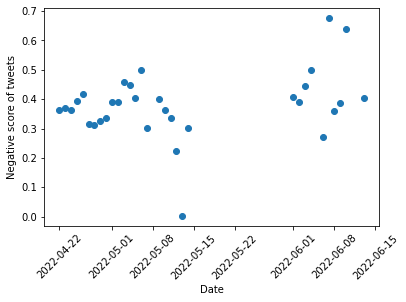

In [31]:
# Get the plot by timeline

plt.scatter(average_df.tweetcreatedts, average_df.negative)
plt.xlabel('Date')
plt.ylabel('Negative score of tweets')
plt.xticks(rotation=45)
plt.show()

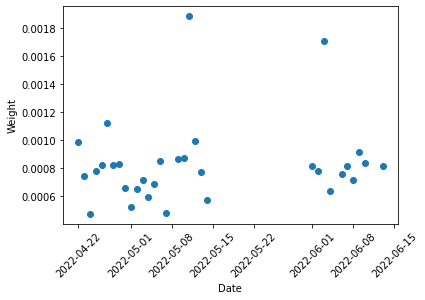

In [32]:
#Get the plot by length of tweet
plt.scatter(average_df.tweetcreatedts, average_df.weight)
plt.xlabel('Date')
plt.ylabel('Weight')
plt.xticks(rotation=45)
plt.show()

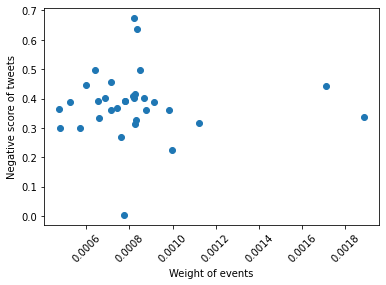

In [33]:
# Get the plot by weight of event
plt.scatter(average_df.weight, average_df.negative)
plt.xlabel('Weight of events')
plt.ylabel('Negative score of tweets')
plt.xticks(rotation=45)
plt.show()

# Linear regression


We assume that we can predict emotional importance of the events of war by the sentiment analysis of tweets. For first segment we use for that simple linear regression, but at the next segment we could try to make clasterisation for Twitter users for more accurate trend prediction.

Our mockup dataset has data for two days only from 180 days of war yet. This is due to the duration of the calculation of sentiment analysis data: even for that two days it took 6 hours to get the result due to size of twitter data.

In [34]:
# Format the data to meet the requirements of the Scikit-learn library
# Examine the first five entries in X
X = average_df.negative.values.reshape(-1, 1)
X[:5]

array([[0.36170226],
       [0.36857997],
       [0.36459413],
       [0.39337882],
       [0.41670945]])

In [35]:
# What is the shape of X - rows and columns
X.shape

(32, 1)

In [36]:
# Assign the target variable, or the Weight column, to y. 
# It's possible to reshape this column, as we did with X, it's not required in this instance
y = average_df.weight
y[:5]

0    0.000985
1    0.000744
2    0.000475
3    0.000779
4    0.000824
Name: weight, dtype: float64

In [37]:
# What is the shape of y - rows and columns
y.shape

(32,)

In [38]:
# Create an instance of the linear regression model
# That will analyze the data and store information specific to this dataset
model = LinearRegression()
model.fit(X,y)

LinearRegression()

In [39]:
# Generate predictions
y_pred = model.predict(X)
print(y_pred.shape)

(32,)


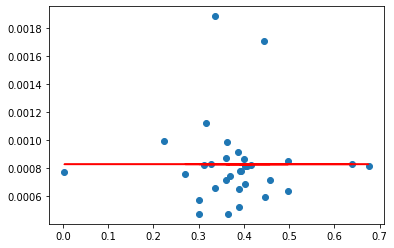

In [40]:
# Plot the predictions as a red line against the data points
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.show()

In [41]:
# Examine the specific parameters of our model: the slope and the y-intercept
print(model.coef_)
print(model.intercept_)

[-1.14529681e-07]
0.0008284826520616052


Looks like despite our idea that average negative sentiment of the day corresponding somehow with the weight of the day (the ratio of the number of articles about relevant news that are written on a given day to the number for all days), it is not, and we were wrong. Let's check this with the Probability Density Function.

# Probability Density Function

PDF is used to specify the probability of the random variable falling within a particular range of values, as opposed to taking on any one value. 

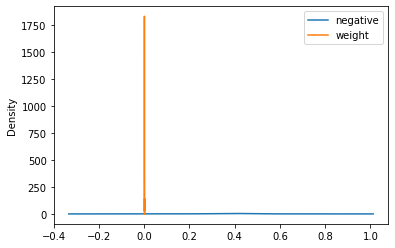

In [42]:
# Generate Kernel Density Estimate plot using Gaussian kernels, using the Density method to fing out

ax = average_df.plot.kde()

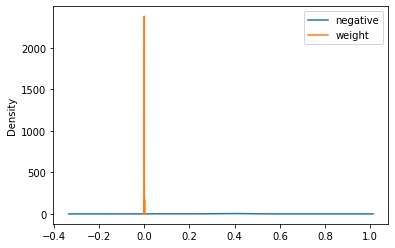

In [44]:
# Using a small bandwidth value 
ax = average_df.plot.kde(bw_method=0.3)

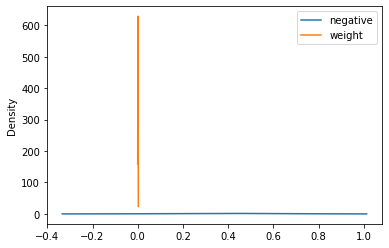

In [48]:
# Using a large bandwidt value
ax = average_df.plot.kde(bw_method=2)

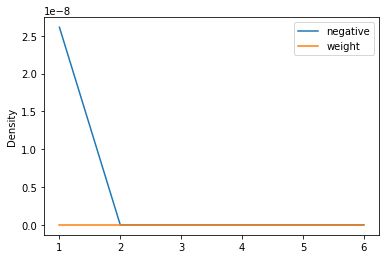

In [47]:
# Determine the evaluation points for the plot of the estimated PDF
ax = average_df.plot.kde(ind=[1, 2, 3, 4, 5, 6])